### Case Study number of blogposts

See: 
http://archive.ics.uci.edu/ml/datasets/BlogFeedback

Status: Under construction. The likelihood of the LR and the mixture model needs checking.


As suggested in the [paper](http://www.cs.bme.hu/~buza/pdfs/gfkl2012_blogs.pdf) and acomaning [talk](http://archive.ics.uci.edu/ml/datasets/BlogFeedback), we use only the base features

#### Results Hits@10 mean and stdderr


##### 20,5 with only base features
LR   5.483   0.181799  #<--- In the paper they had 5.450 +- 1.322 (whatever +- is)

Poisson 5.966 0.1763

ZI Poisson 6.0 0.15

In [1]:
import os
if not os.path.isfile('blogdata/BlogFeedback.zip'):
    !mkdir blogdata
    print("Installing wget")
    !pip install wget
    import wget
    print("Downloading file")
    wget.download('http://archive.ics.uci.edu/ml/machine-learning-databases/00304/BlogFeedback.zip', 'blogdata/BlogFeedback.zip')
    print("Unzipping content")
    !unzip blogdata/BlogFeedback.zip -d blogdata
else:
    print("File exists")

File exists


In [2]:
import tensorflow as tf
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
except:
    IN_COLAB = False
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    if IN_COLAB: #If running in colab install tf 2.0
        !pip install tensorflow==2.0.0-alpha0
        !pip install pip install tfp-nightly==0.7.0-dev20190511
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.0.0-alpha0  running in colab?:  False


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns
import tensorflow_probability as tfp

sns.reset_defaults()
#sns.set_style('whitegrid')
sns.set_context(context='talk',font_scale=0.7)


%matplotlib inline
plt.style.use('default')

tfd = tfp.distributions
tfb = tfp.bijectors
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)
np.random.seed(42)
tf.random.set_seed(42)

TFP Version 0.7.0-dev20190511
TF  Version 2.0.0-alpha0


In [4]:
USE_BASE = True #Use only the Basic features (successfully in paper)

In [5]:
# Loading to the data
d = np.loadtxt("blogdata/blogData_train.csv", delimiter=',', dtype=np.float32)
if USE_BASE:
  Xu = d[:,0:63]
else:
  Xu = d[:,0:279]

y = d[:,280]
d.shape, Xu.shape, y.shape

((52397, 281), (52397, 63), (52397,))

In [6]:
Xmean = np.mean(Xu,axis=0)
Xsd = np.std(Xu,axis=0)
X = (Xu-Xmean)/(Xsd+1e-10)
X = np.clip(X,-5,5)
np.max(X),np.min(X)

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1, random_state=42)

In [7]:
from scipy.stats import spearmanr
def check_performance(model_mean):
  files = [f for f in os.listdir('blogdata/') if f.startswith('blogData_test')]
  hits_at10 = np.zeros(len(files))
  cors = np.zeros(len(files))
  for i,f in enumerate(files):
      d = np.loadtxt("blogdata/"+f, delimiter=',', dtype=np.float32)
      #print("{}".format(i))
      Xtu = d[:,0:X.shape[1]]
      yt = d[:,280]
      Xt = (Xtu-Xmean) / (Xsd+1e-10)
      d.shape, Xtu.shape, yt.shape
      y_pred = model_mean.predict(Xt).flatten()
      idx_true = np.argsort(yt)[-10:]
      idx_pred = np.argsort(y_pred)[-10:] #The 10 higest
      hits_at10[i]=len(np.intersect1d(idx_true, idx_pred))
      cors[i] = spearmanr(yt, y_pred)[0]
  return (np.mean(hits_at10), np.std(hits_at10)/np.sqrt(len(files)),np.mean(cors), np.std(cors)/np.sqrt(len(files)))

In [8]:
spearmanr([1,2,2], [1,2,4])[0]

0.8660254037844387

### Definition of a base model 

In [9]:
## Definition of the base model
from tensorflow.keras.regularizers import l2
# def make_base(inputs):
#     rate = tf.keras.layers.Dense(20,  kernel_regularizer=l2(1e-2),  bias_regularizer=l2(1e-4),activation='sigmoid')(inputs)
#     return tf.keras.layers.Dense(5,  kernel_regularizer=l2(1e-2),  bias_regularizer=l2(1e-4),activation='sigmoid')(rate)

def make_base(inputs):
    return  tf.keras.layers.Dense(3,  kernel_regularizer=l2(1e-2),  bias_regularizer=l2(1e-4),activation='sigmoid')(inputs)
    

epochs = 30



### Fitting Normal

In [10]:
inputs = tf.keras.layers.Input(shape=(X.shape[1],))
out = tf.keras.layers.Dense(1)(make_base(inputs))
model = tf.keras.models.Model(inputs=inputs, outputs=out)
model.compile(optimizer=tf.optimizers.Adam(), loss='mse')
hist = model.fit(X_tr, y_tr, epochs=epochs, verbose=1, validation_data=(X_te, y_te))

Train on 47157 samples, validate on 5240 samples
Epoch 1/30
47157/47157 [==============================] - 1s 31us/sample - loss: 1394.4046 - val_loss: 1737.6228
Epoch 2/30
47157/47157 [==============================] - 1s 30us/sample - loss: 1362.7034 - val_loss: 1709.1299
Epoch 3/30
47157/47157 [==============================] - 1s 27us/sample - loss: 1337.6541 - val_loss: 1685.0708
Epoch 4/30
47157/47157 [==============================] - 1s 27us/sample - loss: 1316.1596 - val_loss: 1663.9462
Epoch 5/30
47157/47157 [==============================] - 1s 26us/sample - loss: 1297.7649 - val_loss: 1645.9506
Epoch 6/30
47157/47157 [==============================] - 1s 26us/sample - loss: 1281.8272 - val_loss: 1629.7474
Epoch 7/30
47157/47157 [==============================] - 1s 26us/sample - loss: 1267.8074 - val_loss: 1615.4919
Epoch 8/30
47157/47157 [==============================] - 1s 27us/sample - loss: 1255.4863 - val_loss: 1603.2084
Epoch 9/30
47157/47157 [=======================

In [11]:
y_hat_tr = model.predict(X_tr) #Trainingset
y_hat_te = model.predict(X_te) #Testset

In [12]:
sigma_hat_2 = np.var(y_hat_tr.flatten() - y_tr) #We estimate sigma from the training set

$$
   NLL/n =  0.5 \cdot \ln (2 \cdot \pi \cdot \sigma^2) + 0.5 * \frac{1}{n} \sum \frac{(y_i-\hat{y_i})^2}{ \sigma^2 }
$$

,hits@10 [mean],hits@10 [std],loss_val [mean],loss_val [std],rank_corr [mean],rank_corr [std]
normal,5.516667,0.162432,5.269432,-1,0.461417,0.011046


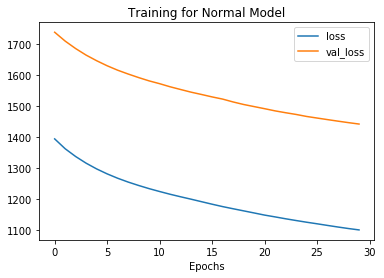

In [13]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.xlabel('Epochs')
plt.title('Training for Normal Model')
np.mean(hist.history['loss'])

d = check_performance(model)

dd =  0.5*np.log(2 * np.pi * sigma_hat_2) + 0.5*np.mean((y_hat_te - y_te)**2)/sigma_hat_2

import pandas as pd
df = pd.DataFrame(
    {'hits@10 [mean]' : d[0], 'hits@10 [std]' : d[1],
    'rank_corr [mean]' : d[2], 'rank_corr [std]' : d[3],
    'loss_val [mean]' : dd, 'loss_val [std]' : -1},
    index=['normal'])
df

In [14]:
np.mean(hist.history['val_loss'][-10:])

1465.2823760179708

### Fitting a poisson

In [15]:
def negloglik(y_true, y_hat):
  return -y_hat.log_prob(y_true)

In [16]:
inputs = tf.keras.layers.Input(shape=(X.shape[1],))
rate = tf.keras.layers.Dense(1, 
                                 activation=tf.exp, 
                                 bias_initializer='zeros', 
                                 kernel_initializer='zeros')(make_base(inputs))

p_y = tfp.layers.DistributionLambda(tfd.Poisson)(rate) 
model = tf.keras.models.Model(inputs=inputs, outputs=p_y)
model_mean = tf.keras.models.Model(inputs=inputs, outputs=p_y.mean()) #For evaluation we need the mean
model.compile(optimizer=tf.optimizers.Adam(), loss=negloglik)

In [17]:
hist = model.fit(X_tr, y_tr, epochs=epochs, verbose=1, validation_data=(X_te, y_te))

Train on 47157 samples, validate on 5240 samples
Epoch 1/30
47157/47157 [==============================] - 2s 39us/sample - loss: 17.1105 - val_loss: 13.0660
Epoch 2/30
47157/47157 [==============================] - 2s 34us/sample - loss: 10.3284 - val_loss: 10.3721
Epoch 3/30
47157/47157 [==============================] - 1s 29us/sample - loss: 8.9881 - val_loss: 9.5987
Epoch 4/30
47157/47157 [==============================] - 1s 29us/sample - loss: 8.3664 - val_loss: 9.1287
Epoch 5/30
47157/47157 [==============================] - 1s 29us/sample - loss: 7.9386 - val_loss: 8.4994
Epoch 6/30
47157/47157 [==============================] - 1s 28us/sample - loss: 7.2443 - val_loss: 8.1440
Epoch 7/30
47157/47157 [==============================] - 1s 27us/sample - loss: 6.9343 - val_loss: 7.9682
Epoch 8/30
47157/47157 [==============================] - 1s 27us/sample - loss: 6.7483 - val_loss: 7.8526
Epoch 9/30
47157/47157 [==============================] - 1s 28us/sample - loss: 6.6451 - v

,hits@10 [mean],hits@10 [std],loss_val [mean],loss_val [std],rank_corr [mean],rank_corr [std]
normal,5.516667,0.162432,5.269432,-1.000000,0.461417,0.011046
Poisson,5.716667,0.179647,7.476394,0.056384,0.495745,0.010436


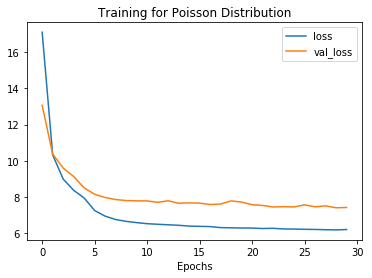

In [18]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.xlabel('Epochs')
plt.title('Training for Poisson Distribution')
np.mean(hist.history['loss'])

d = check_performance(model_mean)

if (epochs > 10):
    dd = np.mean(hist.history['val_loss'][-10:])
    ddd = np.std(hist.history['val_loss'][-10:])
else:
    dd = ddd = -1.
import pandas as pd
df1 = pd.DataFrame(
    {'hits@10 [mean]' : d[0], 'hits@10 [std]' : d[1],
     'rank_corr [mean]' : d[2], 'rank_corr [std]' : d[3],
    'loss_val [mean]' : dd, 'loss_val [std]' : ddd},
    index=['Poisson'])
df = df.append(df1)
df

### Fitting ZIP

In [19]:
def zero_inf(out): 
    rate = tf.math.exp(out[:,0]) #A 
    #rate = tf.math.softplus(out[:,0]) #A 
    s = tf.math.sigmoid(out[:,1:]) #B  
    probs = tf.concat([s, 1-s], axis=1) #C 
    print(np.min(rate), " ", np.max(rate), " ", np.min(s), np.max(s),"  ",np.min(out[:,1:]), np.max(out[:,1:]))
    return tfd.Mixture(
          cat=tfd.Categorical(probs=probs),#D
          components=[
            tfd.Deterministic(loc=tf.zeros_like(rate)), #E
            tfd.Poisson(rate=rate), #F 
        ])

In [20]:
def negloglik2(y_true, y_hat):
    # return -tf.reduce_mean(y_hat.log_prob(y_true))
    return -tf.reduce_mean(y_hat.log_prob(tf.reshape(y_true,(-1,))))

In [21]:
#   One pah for all
# from tensorflow.keras.regularizers import l2
# inputs = tf.keras.layers.Input(shape=(X.shape[1],))
# rate = tf.keras.layers.Dense(2,  kernel_regularizer=l2(0.01))(make_base(inputs))

# p_y = tfp.layers.DistributionLambda(zero_inf)(rate) 
# model = tf.keras.models.Model(inputs=inputs, outputs=p_y)
# model_mean = tf.keras.models.Model(inputs=inputs, outputs=p_y.mean()) #For evaluation we need the mean
# model.compile(optimizer=tf.optimizers.Adam(), loss=negloglik2)
# model.summary()

In [22]:
from tensorflow.keras.regularizers import l2
inputs = tf.keras.layers.Input(shape=(X.shape[1],))
mean = tf.keras.layers.Dense(1,  kernel_regularizer=l2(0.01))(make_base(inputs))
z = tf.keras.layers.Dense(1,  kernel_regularizer=l2(0.01))(make_base(inputs))
tt = tf.concat([mean, z], axis=1)
p_y = tfp.layers.DistributionLambda(zero_inf)(tt) 
model = tf.keras.models.Model(inputs=inputs, outputs=p_y)
model_mean = tf.keras.models.Model(inputs=inputs, outputs=p_y.mean()) #For evaluation we need the mean
model.compile(optimizer=tf.optimizers.Adam(), loss=negloglik2)
model.summary()

W0618 20:53:20.159106 139629362722560 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow_probability/python/distributions/mixture.py:154: Categorical.event_size (from tensorflow_probability.python.distributions.categorical) is deprecated and will be removed after 2019-05-19.
Instructions for updating:
The `event_size` property is deprecated.  Use `num_categories` instead.  They have the same value, but `event_size` is misnamed.


Tensor("distribution_lambda_1/Exp:0", shape=(None,), dtype=float32)   Tensor("distribution_lambda_1/Exp:0", shape=(None,), dtype=float32)   Tensor("distribution_lambda_1/Sigmoid:0", shape=(None, 1), dtype=float32) Tensor("distribution_lambda_1/Sigmoid:0", shape=(None, 1), dtype=float32)    Tensor("distribution_lambda_1/strided_slice_2:0", shape=(None, 1), dtype=float32) Tensor("distribution_lambda_1/strided_slice_3:0", shape=(None, 1), dtype=float32)
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 63)]         0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 3)            192         input_3[0][0]                    
_________________________________

In [23]:
hist = model.fit(X_tr, y_tr, epochs=epochs, verbose=1, validation_data=(X_te, y_te))

Train on 47157 samples, validate on 5240 samples
Epoch 1/30
47157/47157 [==============================] - 2s 44us/sample - loss: 13.9619 - val_loss: 9.8183
Epoch 2/30
47157/47157 [==============================] - 2s 35us/sample - loss: 7.6936 - val_loss: 7.7355
Epoch 3/30
47157/47157 [==============================] - 2s 34us/sample - loss: 6.5247 - val_loss: 7.0010
Epoch 4/30
47157/47157 [==============================] - 2s 34us/sample - loss: 6.0315 - val_loss: 6.7262
Epoch 5/30
47157/47157 [==============================] - 2s 34us/sample - loss: 5.8260 - val_loss: 6.6972
Epoch 6/30
47157/47157 [==============================] - 2s 35us/sample - loss: 5.7079 - val_loss: 6.5443
Epoch 7/30
47157/47157 [==============================] - 2s 38us/sample - loss: 5.6316 - val_loss: 6.5693
Epoch 8/30
47157/47157 [==============================] - 2s 35us/sample - loss: 5.5877 - val_loss: 6.4839
Epoch 9/30
47157/47157 [==============================] - 2s 35us/sample - loss: 5.5706 - val_

,hits@10 [mean],hits@10 [std],loss_val [mean],loss_val [std],rank_corr [mean],rank_corr [std]
normal,5.516667,0.162432,5.269432,-1.000000,0.461417,0.011046
Poisson,5.716667,0.179647,7.476394,0.056384,0.495745,0.010436
ZIP,5.416667,0.173672,6.277303,0.040061,0.493976,0.009645


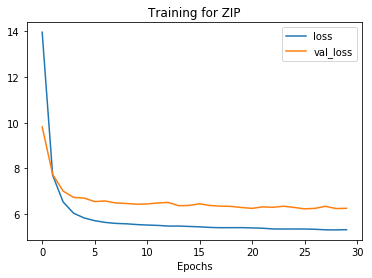

In [24]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.xlabel('Epochs')
plt.title('Training for ZIP')
np.mean(hist.history['loss'])

d = check_performance(model_mean)
if (epochs > 10):
    dd = np.mean(hist.history['val_loss'][-10:])
    ddd = np.std(hist.history['val_loss'][-10:])
else:
    dd = ddd = -1.
import pandas as pd
df1 = pd.DataFrame(
    {'hits@10 [mean]' : d[0], 'hits@10 [std]' : d[1],
     'rank_corr [mean]' : d[2], 'rank_corr [std]' : d[3],
    'loss_val [mean]' : dd, 'loss_val [std]' : ddd},
    index=['ZIP'])
df = df.append(df1)
df

### Definition of a Mixture Model

In [25]:
# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234
#See https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/QuantizedDistribution
def mixture_logistic(out, num=3): 
    loc, un_scale, logits = tf.split(out,
                                     num_or_size_splits=num,
                                     axis=-1)
    scale = tf.nn.softplus(un_scale)

    discretized_logistic_dist=tfd.TransformedDistribution(
        distribution=tfd.Logistic(loc=loc, scale=scale),
        bijector=tfb.AffineScalar(shift=-0.5))
    
    #print("mix_logi ", np.min(logits), " ", np.max(logits), " ", np.min(scale), np.max(scale),"  ",np.min(loc), np.max(loc))
    mixture_dist = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(logits=logits), #logits will be normalized to one
        components_distribution=discretized_logistic_dist)
    return mixture_dist

In [26]:
from tensorflow.keras.regularizers import l2
inputs = tf.keras.layers.Input(shape=(X.shape[1],))

loc1    = tf.keras.layers.Dense(3,  kernel_regularizer=l2(0.01))(make_base(inputs))
scales1 = tf.keras.layers.Dense(3,  kernel_regularizer=l2(0.01))(make_base(inputs))
logits  = tf.keras.layers.Dense(3,  kernel_regularizer=l2(0.01))(make_base(inputs))

tt = tf.concat([loc1, scales1, logits], axis=1)
p_y = tfp.layers.DistributionLambda(mixture_logistic)(tt) 
model = tf.keras.models.Model(inputs=inputs, outputs=p_y)
model_mean = tf.keras.models.Model(inputs=inputs, outputs=p_y.mean()) #For evaluation we need the mean
model.compile(optimizer=tf.optimizers.Adam(), loss=negloglik2)
model.summary()


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 63)]         0                                            
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 3)            192         input_4[0][0]                    
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 3)            192         input_4[0][0]                    
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 3)            192         input_4[0][0]                    
____________________________________________________________________________________________

In [27]:
hist = model.fit(X_tr, y_tr, epochs=epochs, verbose=1, validation_data=(X_te, y_te))

Train on 47157 samples, validate on 5240 samples
Epoch 1/30
47157/47157 [==============================] - 2s 43us/sample - loss: 2.9366 - val_loss: 0.2450
Epoch 2/30
47157/47157 [==============================] - 2s 37us/sample - loss: -0.7506 - val_loss: -1.2050
Epoch 3/30
47157/47157 [==============================] - 2s 37us/sample - loss: -1.3668 - val_loss: -1.6207
Epoch 4/30
47157/47157 [==============================] - 2s 37us/sample - loss: -1.6390 - val_loss: -1.7949
Epoch 5/30
47157/47157 [==============================] - 2s 37us/sample - loss: -1.8440 - val_loss: -2.0301
Epoch 6/30
47157/47157 [==============================] - 2s 37us/sample - loss: -1.8815 - val_loss: -1.2176
Epoch 7/30
47157/47157 [==============================] - 2s 36us/sample - loss: -1.9556 - val_loss: -2.0476
Epoch 8/30
47157/47157 [==============================] - 2s 36us/sample - loss: -2.0291 - val_loss: -1.9332
Epoch 9/30
47157/47157 [==============================] - 2s 36us/sample - loss: 

,hits@10 [mean],hits@10 [std],loss_val [mean],loss_val [std],rank_corr [mean],rank_corr [std]
normal,5.516667,0.162432,5.269432,-1.000000,0.461417,0.011046
Poisson,5.716667,0.179647,7.476394,0.056384,0.495745,0.010436
ZIP,5.416667,0.173672,6.277303,0.040061,0.493976,0.009645
Mixture,4.950000,0.175476,-2.469294,0.214170,0.525798,0.009373


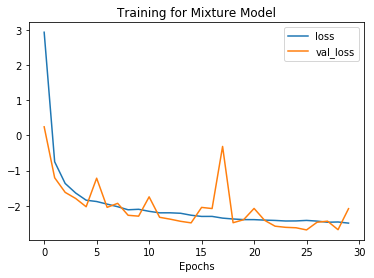

In [28]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.xlabel('Epochs')
plt.title('Training for Mixture Model')
np.mean(hist.history['loss'])

d = check_performance(model_mean)
if (epochs > 10):
    dd = np.mean(hist.history['val_loss'][-10:])
    ddd = np.std(hist.history['val_loss'][-10:])
else:
    dd = ddd = -1.
import pandas as pd
df1 = pd.DataFrame(
    {'hits@10 [mean]' : d[0], 'hits@10 [std]' : d[1],
     'rank_corr [mean]' : d[2], 'rank_corr [std]' : d[3],
    'loss_val [mean]' : dd, 'loss_val [std]' : ddd},
    index=['Mixture'])
df = df.append(df1)
df

In [29]:
df

,hits@10 [mean],hits@10 [std],loss_val [mean],loss_val [std],rank_corr [mean],rank_corr [std]
normal,5.516667,0.162432,5.269432,-1.000000,0.461417,0.011046
Poisson,5.716667,0.179647,7.476394,0.056384,0.495745,0.010436
ZIP,5.416667,0.173672,6.277303,0.040061,0.493976,0.009645
Mixture,4.950000,0.175476,-2.469294,0.214170,0.525798,0.009373
